In [1]:
import numpy as np 
import pandas as pd
images = []
label = []
import os
for dirname, _, filenames in os.walk('/kaggle/input/fruits-dataset-images/images'):
    for filename in filenames:
        images.append(os.path.join(dirname, filename).split('/')[-1])
        label.append(os.path.join(dirname, filename).split('/')[-2])

In [2]:
import matplotlib.pyplot as plt
from torchvision import transforms as T
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import time
from torch.nn import functional as F
from torchvision import models
import torch.nn as nn
import torch
import random
import PIL

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
labels = np.unique(label)
ints = np.arange(0, len(label))
dicts = dict(zip(labels, ints))
dicts

{'apple fruit': 0,
 'banana fruit': 1,
 'cherry fruit': 2,
 'chickoo fruit': 3,
 'grapes fruit': 4,
 'kiwi fruit': 5,
 'mango fruit': 6,
 'orange fruit': 7,
 'strawberry fruit': 8}

In [4]:
import pandas as pd
from PIL import Image

PATH = "/kaggle/input/fruits-dataset-images/images/"

df_full = pd.DataFrame({'image_id': images, 'label': label})

# FINDING BAD FILE

index = []
for i in range(len(df_full)):
    try:
        Image.open(PATH + str(df_full['label'].values[i]) + '/' + str(df_full['image_id'].values[i]))
    except PIL.UnidentifiedImageError:
        index.append(i)

df = df_full.drop(index)
df.head()

,image_id,label
0,Image_22.jpg,apple fruit
1,Image_34.jpeg,apple fruit
2,Image_13.png,apple fruit
3,Image_4.jpg,apple fruit
4,Image_12.jpg,apple fruit


In [5]:
class Batik(Dataset):
    def __init__(self, x, y, path, map_label=dicts, transform=None):
        self.X = x
        self.y = y
        self.path = path
        self.map_label = map_label
        self.transform = transform
        
    def __getitem__(self, idx):
        img = Image.open(self.path + str(self.y[idx]) + '/' + str(self.X[idx])).convert('RGB')
        label = self.map_label[self.y[idx]]
        
        if self.transform is not None:
            img = self.transform(img)
            
        return img, label

    def __len__(self):
        return len(self.X)
    
X_trainval, X_test, y_trainval, y_test = train_test_split(
    df['image_id'].values, df['label'].values, 
    test_size=0.15, stratify=df['label'].values, 
    random_state=77)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, 
    stratify=y_trainval, test_size=0.15,
    random_state=77)


len(X_train), len(X_val), len(X_test)

(260, 46, 54)

In [6]:
X_trainval, X_test, y_trainval, y_test = train_test_split(
    df['image_id'].values, df['label'].values,
    test_size=0.1, stratify=df['label'].values, random_state=42
)

In [7]:
mean= [0.485, 0.456, 0.406] 
std= [0.229, 0.224, 0.225]
batch_size = 24

train_transform = T.Compose([T.Resize((128, 128)),
                             T.RandomHorizontalFlip(),
                             T.RandomVerticalFlip(),
                             T.RandomRotation(20),
                             T.ToTensor(),
                             T.Normalize(mean, std)
                            ])

val_transform = T.Compose([T.Resize((128, 128)),
                           T.ToTensor(),
                           T.Normalize(mean, std),
                          ])

train_set = Batik(X_train, y_train, PATH, transform=train_transform)
val_set = Batik(X_val, y_val, PATH, transform=val_transform)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, 
                                           num_workers=8, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=batch_size*2, shuffle=False, 
                                         num_workers=8, pin_memory=True)

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [8]:
mean= [0.485, 0.456, 0.406] 
std= [0.229, 0.224, 0.225]
batch_size = 24

train_transform = T.Compose([T.Resize((128, 128)),
                             T.RandomHorizontalFlip(),
                             T.RandomVerticalFlip(),
                             T.RandomRotation(20),
                             T.ToTensor(),
                             T.Normalize(mean, std)
                            ])

val_transform = T.Compose([T.Resize((128, 128)),
                           T.ToTensor(),
                           T.Normalize(mean, std),
                          ])

train_set = Batik(X_train, y_train, PATH, transform=train_transform)
val_set = Batik(X_val, y_val, PATH, transform=val_transform)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, 
                                           num_workers=8, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=batch_size*2, shuffle=False, 
                                         num_workers=8, pin_memory=True)

orange fruit


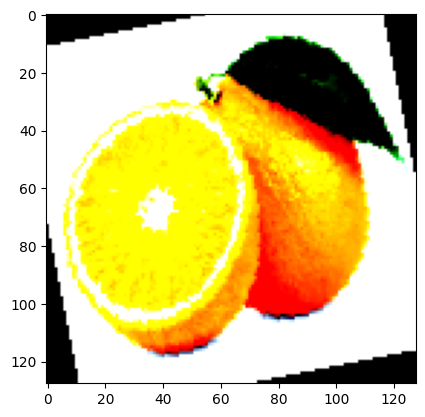

In [9]:
int_label = dict(zip(ints, labels))


img, label = train_set[random.randint(0, len(X_train))]
plt.imshow(img.permute(1,2,0));
print(int_label[label])

In [10]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(in_features=512, out_features=20, bias=True)
model

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 108MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
def accuracy(output, label):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, label).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

epoch = 20
lr = 1e-3
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, epochs=epoch,
                                               steps_per_epoch=len(train_loader))

In [12]:
train_losses = []
val_losses =[]
train_accuracy = []
val_acc = []
for e in range(epoch):
    model.to(device)
    model.train()

    train_loss = 0
    train_acc = 0
    since = time.time()
    for image, label in tqdm(train_loader, total=len(train_loader)):
      #for image, label in tqdm(train_loader, total=len(train_loader), desc=f'Epoch {epoch + 1}/{num_epochs}'):
        optimizer.zero_grad()
        optimizer.zero_grad()

        image = image.to(device)
        label = label.to(device)
        output = model(image)
        loss = criterion(output, label)

        train_loss += loss
        train_acc += accuracy(output, label)

        loss.backward()
        optimizer.step()
        scheduler.step()

    else:
        with torch.no_grad():
            model.eval()

            running_loss = 0
            val_accuracy =0
            for image, label in val_loader:
                image = image.to(device)
                label = label.to(device)

                output = model(image)
                loss = criterion(output, label)
                val_accuracy += accuracy(output, label)
                running_loss += loss

    train_losses.append((train_loss/len(train_loader)).item())
    val_losses.append((running_loss/len(val_loader)).item())
    train_accuracy.append(train_acc/ len(train_loader))
    val_acc.append(val_accuracy/len(val_loader))

    print('epochs {}/{}..'.format(e+1, epoch),
          'train loss {:.3f}..'.format(train_loss/len(train_loader)),
          'val loss {:.3f}..'.format(running_loss/len(val_loader)),
          'train accuracy {:.3f}..'.format(train_acc/ len(train_loader)),
          'val accuracy {:.3f}..'.format(val_accuracy/len(val_loader)),
          'time {:.3f} s'.format(time.time() - since)
         )

  0%|          | 0/11 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epochs 1/20.. train loss 2.641.. val loss 1.925.. train accuracy 0.251.. val accuracy 0.457.. time 22.350 s


  0%|          | 0/11 [00:00<?, ?it/s]

epochs 2/20.. train loss 1.220.. val loss 0.904.. train accuracy 0.743.. val accuracy 0.674.. time 22.717 s


  0%|          | 0/11 [00:00<?, ?it/s]

epochs 3/20.. train loss 0.475.. val loss 0.678.. train accuracy 0.862.. val accuracy 0.783.. time 22.456 s


  0%|          | 0/11 [00:00<?, ?it/s]

epochs 4/20.. train loss 0.274.. val loss 0.695.. train accuracy 0.911.. val accuracy 0.783.. time 21.720 s


  0%|          | 0/11 [00:00<?, ?it/s]

epochs 5/20.. train loss 0.413.. val loss 1.239.. train accuracy 0.861.. val accuracy 0.717.. time 22.219 s


  0%|          | 0/11 [00:00<?, ?it/s]

epochs 6/20.. train loss 0.802.. val loss 5.888.. train accuracy 0.783.. val accuracy 0.565.. time 22.137 s


  0%|          | 0/11 [00:00<?, ?it/s]

epochs 7/20.. train loss 0.877.. val loss 4.296.. train accuracy 0.723.. val accuracy 0.500.. time 21.762 s


  0%|          | 0/11 [00:00<?, ?it/s]

epochs 8/20.. train loss 0.690.. val loss 3.884.. train accuracy 0.767.. val accuracy 0.457.. time 22.112 s


  0%|          | 0/11 [00:00<?, ?it/s]

epochs 9/20.. train loss 0.779.. val loss 4.673.. train accuracy 0.778.. val accuracy 0.609.. time 22.430 s


  0%|          | 0/11 [00:00<?, ?it/s]

epochs 10/20.. train loss 0.420.. val loss 1.193.. train accuracy 0.885.. val accuracy 0.674.. time 21.599 s


  0%|          | 0/11 [00:00<?, ?it/s]

epochs 11/20.. train loss 0.267.. val loss 1.219.. train accuracy 0.901.. val accuracy 0.674.. time 21.195 s


  0%|          | 0/11 [00:00<?, ?it/s]

epochs 12/20.. train loss 0.474.. val loss 1.146.. train accuracy 0.870.. val accuracy 0.739.. time 22.119 s


  0%|          | 0/11 [00:00<?, ?it/s]

epochs 13/20.. train loss 0.217.. val loss 0.881.. train accuracy 0.927.. val accuracy 0.783.. time 21.820 s


  0%|          | 0/11 [00:00<?, ?it/s]

epochs 14/20.. train loss 0.151.. val loss 0.588.. train accuracy 0.944.. val accuracy 0.826.. time 21.681 s


  0%|          | 0/11 [00:00<?, ?it/s]

epochs 15/20.. train loss 0.134.. val loss 0.464.. train accuracy 0.964.. val accuracy 0.826.. time 22.116 s


  0%|          | 0/11 [00:00<?, ?it/s]

epochs 16/20.. train loss 0.104.. val loss 0.523.. train accuracy 0.965.. val accuracy 0.848.. time 21.956 s


  0%|          | 0/11 [00:00<?, ?it/s]

epochs 17/20.. train loss 0.157.. val loss 0.436.. train accuracy 0.952.. val accuracy 0.891.. time 21.344 s


  0%|          | 0/11 [00:00<?, ?it/s]

epochs 18/20.. train loss 0.043.. val loss 0.451.. train accuracy 0.992.. val accuracy 0.891.. time 22.059 s


  0%|          | 0/11 [00:00<?, ?it/s]

epochs 19/20.. train loss 0.086.. val loss 0.434.. train accuracy 0.973.. val accuracy 0.891.. time 22.182 s


  0%|          | 0/11 [00:00<?, ?it/s]

epochs 20/20.. train loss 0.067.. val loss 0.461.. train accuracy 0.981.. val accuracy 0.891.. time 21.408 s


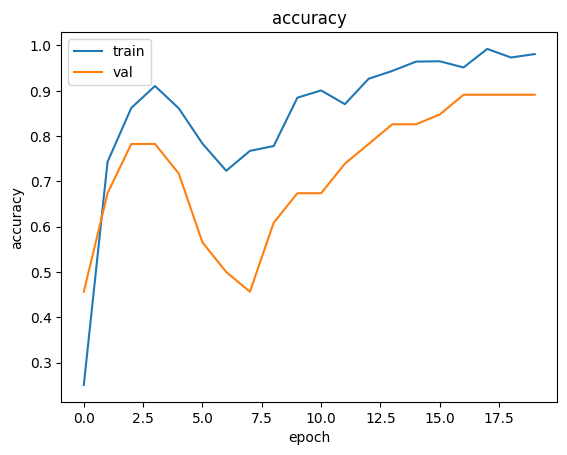

In [13]:
plt.plot(train_accuracy, label='train')
plt.title('accuracy')
plt.ylabel('accuracy'); plt.xlabel('epoch')
plt.plot(val_acc, label='val')
plt.legend()
plt.show()

In [14]:
test_set = Batik(X_test, y_test, PATH, transform=val_transform)

def predict(model, img, label):
    model.eval()
    with torch.no_grad():
        img = img.unsqueeze(0).to(device)
        output = model(img)
        pred = torch.argmax(F.softmax(output, dim=1)).cpu().item()
    return pred

test_predict = []
true_label = []
for i in range(len(test_set)):
    img, label = test_set[i]
    prediction = predict(model, img, label)
    test_predict.append(prediction)
    true_label.append(label)

In [15]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(true_label, test_predict))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         4
           2       0.80      1.00      0.89         4
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         4
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         4
           7       1.00      1.00      1.00         4
           8       1.00      0.75      0.86         4

    accuracy                           0.97        36
   macro avg       0.98      0.97      0.97        36
weighted avg       0.98      0.97      0.97        36



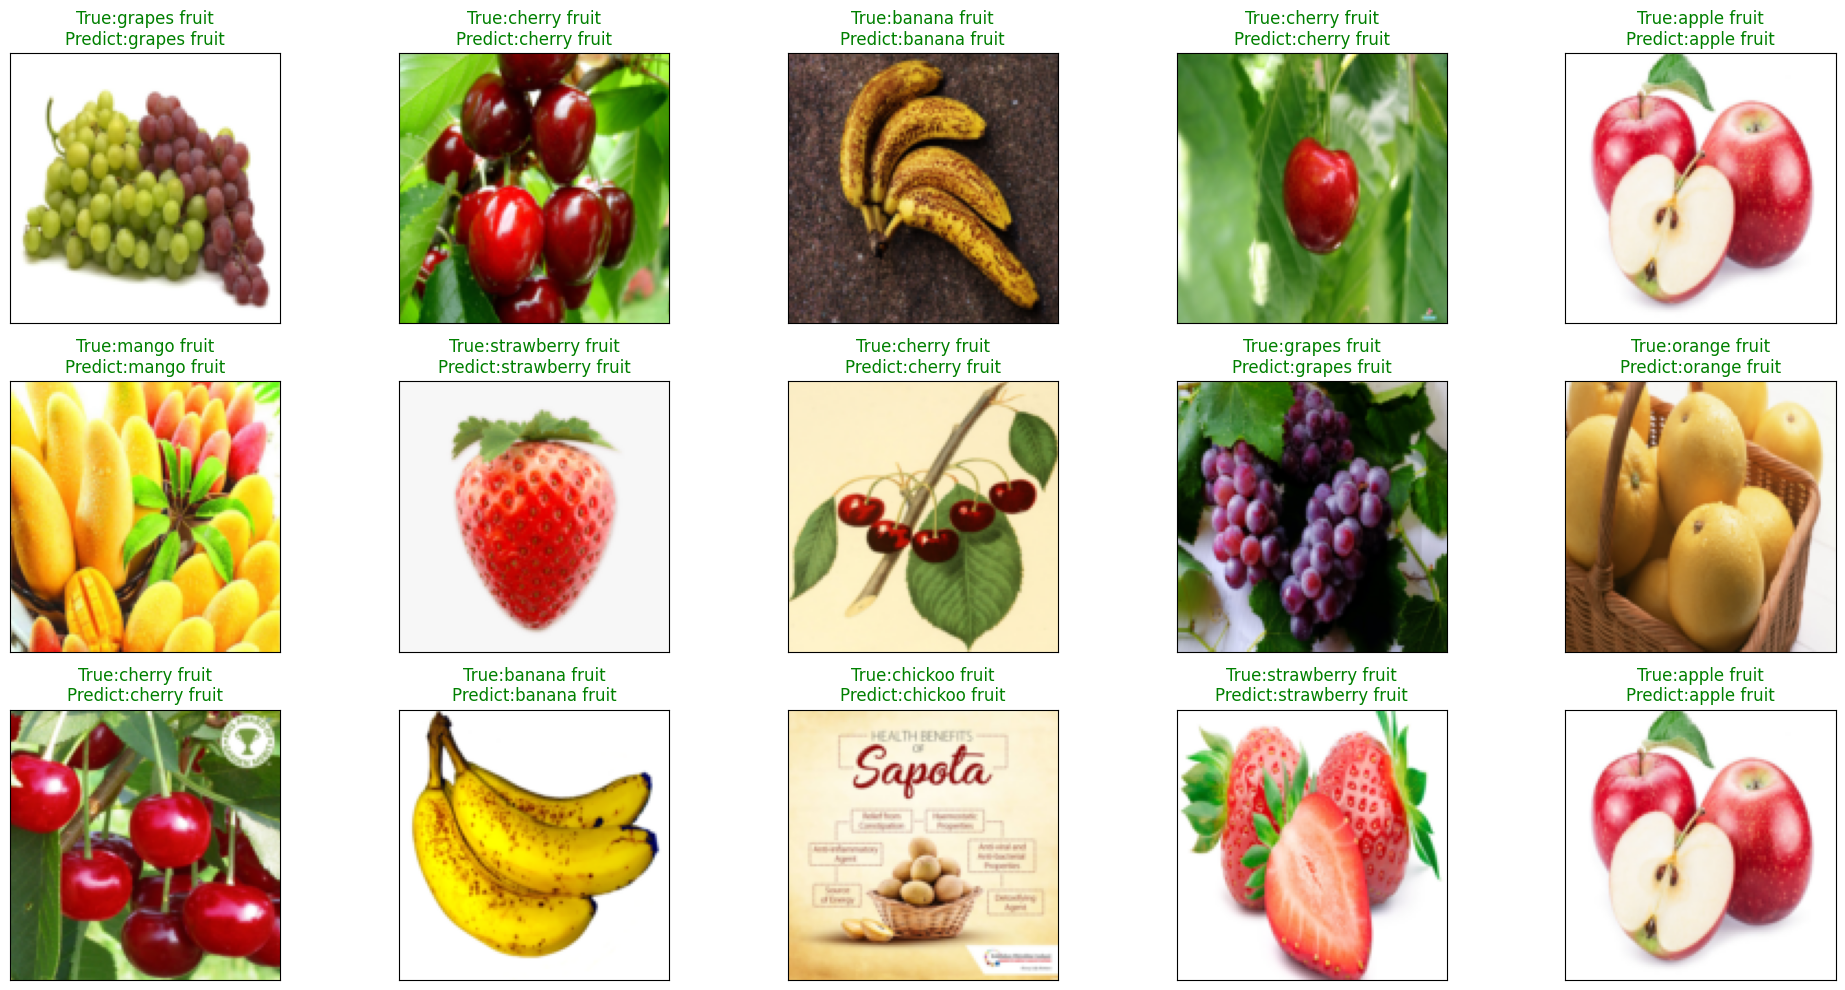

In [16]:
random_selection = np.random.randint(0, len(test_predict), 15)

fig = plt.figure(figsize=(20, 10))

test_set = Batik (X_test, y_test, PATH, transform=T.Resize((124,124)))
for i, idx in enumerate(random_selection):
    image, label = test_set[idx]
    ax = fig.add_subplot(3, 5, i+1, xticks=[], yticks = [])
    ax.imshow(image)
    ax.set_title('True:{}\nPredict:{}'.format(int_label[label], int_label[test_predict[idx]]),
                color=("green" if label == test_predict[idx] else 'red'), fontsize=12)

plt.tight_layout() #want faster comment or delete this
plt.show()